In [1]:
import os

def print_tree(root_dir):
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}📁 {os.path.basename(root)}/")

        subindent = " " * 4 * (level + 1)
        for f in files:
            print(f"{subindent}📄 {f}")




In [2]:
# Ví dụ
print_tree(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)")

📁 3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)/
    📄 gadds_download.log
    📄 Magmap2019-grid-tmi-AWAGS_MAG_2019.tif
    📄 Magmap2019-grid-tmi-AWAGS_MAG_2019.tif.aux.xml
    📄 Magmap2019-grid-tmi-AWAGS_MAG_2019_license.txt
    📄 Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif
    📄 Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif.aux.xml
    📄 Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_license.txt
    📄 Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif
    📄 Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif.aux.xml
    📄 Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019_license.txt
    📄 request.json
    📁 processed_nt/
        📄 Magmap2019-grid-tmi-AWAGS_MAG_2019.tif
        📄 Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif
        📄 Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif


In [3]:
import rasterio
from pathlib import Path

folder = Path(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)")
paths = {
    "tmi": folder / "Magmap2019-grid-tmi-AWAGS_MAG_2019.tif",
    "rtp": folder / "Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif",
    "1vd": folder / "Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif",
}

for k,p in paths.items():
    with rasterio.open(p) as src:
        print("\n", k, p.name)
        print("CRS:", src.crs)
        print("Res:", src.res)
        print("Bounds:", src.bounds)
        print("Shape:", (src.height, src.width))
        print("Dtype:", src.dtypes[0])



 tmi Magmap2019-grid-tmi-AWAGS_MAG_2019.tif
CRS: EPSG:4283
Res: (0.0008500000000000001, 0.0008500000000000001)
Bounds: BoundingBox(left=129.00025000000002, bottom=-25.99895, right=137.99920000000003, top=-9.3381)
Shape: (19601, 10587)
Dtype: float32

 rtp Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif
CRS: EPSG:4283
Res: (0.0008500000000000001, 0.0008500000000000001)
Bounds: BoundingBox(left=129.00025000000002, bottom=-25.99895, right=137.99920000000003, top=-9.3381)
Shape: (19601, 10587)
Dtype: float32

 1vd Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif
CRS: EPSG:4283
Res: (0.0008500000000000001, 0.0008500000000000001)
Bounds: BoundingBox(left=129.00025000000002, bottom=-25.99895, right=137.99920000000003, top=-9.3381)
Shape: (19601, 10587)
Dtype: float32


In [5]:
out_dir = folder / "processed_nt"
out_dir.mkdir(exist_ok=True)

In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pathlib import Path

def reproject_raster(
    in_path,
    out_path,
    dst_crs="EPSG:28352",
    resampling=Resampling.bilinear
):
    """
    Reproject a clipped raster to target CRS.
    Assumes raster already clipped to AOI (NT).
    """

    in_path = Path(in_path)
    out_path = Path(out_path)

    with rasterio.open(in_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs,
            dst_crs,
            src.width,
            src.height,
            *src.bounds
        )

        meta = src.meta.copy()
        meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(out_path, "w", **meta) as dst:
            for band in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, band),
                    destination=rasterio.band(dst, band),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling
                )


In [4]:
from pathlib import Path

in_dir = Path(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt")
out_dir = in_dir / "reprojected_28352"
out_dir.mkdir(exist_ok=True)

files = {
    "tmi": "Magmap2019-grid-tmi-AWAGS_MAG_2019.tif",
    "rtp": "Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif",
    "1vd": "Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif",
}

for k, fname in files.items():
    reproject_raster(
        in_dir / fname,
        out_dir / f"{k}_nt_28352.tif"
    )


In [5]:
import rasterio

for f in out_dir.glob("*.tif"):
    with rasterio.open(f) as src:
        print(f.name)
        print(" CRS:", src.crs)
        print(" Res:", src.res)
        print(" Bounds:", src.bounds)
        print()

1vd_nt_28352.tif
 CRS: EPSG:28352
 Res: (93.39944590371834, 93.39944590371834)
 Bounds: BoundingBox(left=500025.01963932277, bottom=7093147.803954789, right=1492113.934028619, top=8967768.08268832)

rtp_nt_28352.tif
 CRS: EPSG:28352
 Res: (93.39944590371834, 93.39944590371834)
 Bounds: BoundingBox(left=500025.01963932277, bottom=7093147.803954789, right=1492113.934028619, top=8967768.08268832)

tmi_nt_28352.tif
 CRS: EPSG:28352
 Res: (93.39944590371834, 93.39944590371834)
 Bounds: BoundingBox(left=500025.01963932277, bottom=7093147.803954789, right=1492113.934028619, top=8967768.08268832)



In [7]:
import numpy as np
import rasterio
from pathlib import Path

folder = Path(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt")  # sửa path

files = {
    "tmi": folder / "Magmap2019-grid-tmi-AWAGS_MAG_2019.tif",
    "rtp": folder / "Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif",
    "1vd": folder / "Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif",
}

def raster_summary(path):
    with rasterio.open(path) as src:
        arr = src.read(1, masked=True)  # masked array (tự mask NoData)
        summary = {
            "file": path.name,
            "crs": str(src.crs),
            "res": src.res,
            "shape": (src.height, src.width),
            "dtype": src.dtypes[0],
            "nodata": src.nodata,
            "min": float(arr.min()),
            "max": float(arr.max()),
            "mean": float(arr.mean()),
            "std": float(arr.std()),
            "valid_px": int(arr.count()),
            "total_px": int(arr.size),
        }
    return summary

for k, p in files.items():
    s = raster_summary(p)
    print(f"\n=== {k.upper()} ===")
    for kk, vv in s.items():
        print(f"{kk:10}: {vv}")



=== TMI ===
file      : Magmap2019-grid-tmi-AWAGS_MAG_2019.tif
crs       : EPSG:4283
res       : (0.0008500000000000001, 0.0008500000000000001)
shape     : (19601, 10587)
dtype     : float32
nodata    : -99999.0
min       : -3195.412841796875
max       : 5546.9169921875
mean      : -73.26468239784964
std       : 166.70580217616953
valid_px  : 181311052
total_px  : 207515787

=== RTP ===
file      : Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif
crs       : EPSG:4283
res       : (0.0008500000000000001, 0.0008500000000000001)
shape     : (19601, 10587)
dtype     : float32
nodata    : -99999.0
min       : -3789.618408203125
max       : 6149.951171875
mean      : 9.649183340132078
std       : 195.74515808053667
valid_px  : 181357020
total_px  : 207515787

=== 1VD ===
file      : Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif
crs       : EPSG:4283
res       : (0.0008500000000000001, 0.0008500000000000001)
shape     : (19601, 10587)
dtype     : float32
nodata    : -99999.0
min       : -18.874118804

In [8]:
import rasterio
import numpy as np

def show_window_values(path, win=15):
    with rasterio.open(path) as src:
        r0 = src.height // 2 - win // 2
        c0 = src.width  // 2 - win // 2
        window = rasterio.windows.Window(c0, r0, win, win)
        arr = src.read(1, window=window, masked=True)
        # in gọn, làm tròn cho dễ nhìn
        a = np.array(arr.filled(np.nan))
        return np.round(a, 2)

for k,p in files.items():
    print(f"\n{k.upper()} sample window (center {15}x{15}):")
    print(show_window_values(p, win=15))



TMI sample window (center 15x15):
[[-163.67 -163.45 -163.22 -163.   -162.79 -162.61 -162.43 -162.28 -162.14
  -162.02 -161.93 -161.87 -161.87 -161.92 -161.99]
 [-163.59 -163.39 -163.18 -162.98 -162.8  -162.63 -162.48 -162.35 -162.23
  -162.13 -162.07 -162.05 -162.09 -162.18 -162.31]
 [-163.52 -163.32 -163.13 -162.94 -162.78 -162.63 -162.49 -162.38 -162.28
  -162.21 -162.18 -162.2  -162.27 -162.4  -162.58]
 [-163.46 -163.27 -163.09 -162.92 -162.76 -162.61 -162.48 -162.37 -162.29
  -162.25 -162.25 -162.31 -162.42 -162.6  -162.81]
 [-163.45 -163.26 -163.09 -162.92 -162.74 -162.58 -162.45 -162.35 -162.29
  -162.28 -162.32 -162.42 -162.57 -162.79 -163.05]
 [-163.47 -163.28 -163.1  -162.92 -162.74 -162.57 -162.42 -162.33 -162.29
  -162.32 -162.4  -162.54 -162.74 -163.   -163.3 ]
 [-163.49 -163.29 -163.1  -162.91 -162.72 -162.55 -162.41 -162.33 -162.32
  -162.38 -162.5  -162.69 -162.93 -163.23 -163.56]
 [-163.48 -163.27 -163.07 -162.88 -162.71 -162.55 -162.43 -162.36 -162.38
  -162.48 -162.6

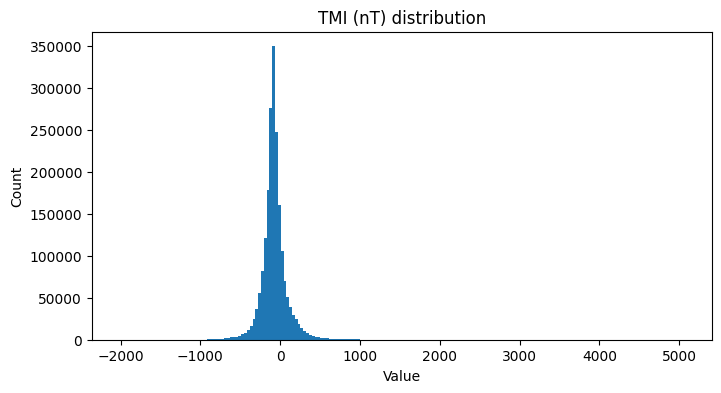

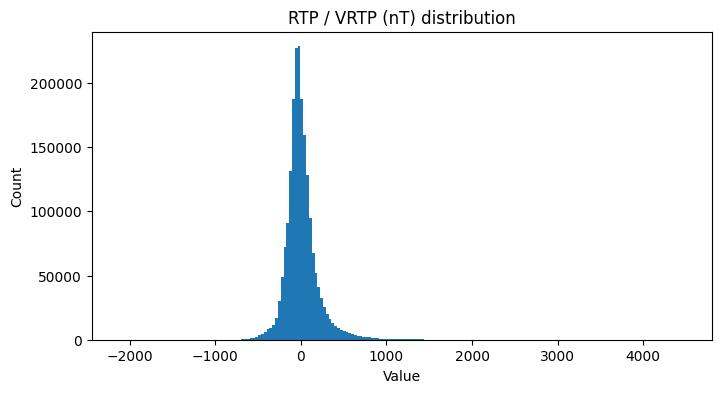

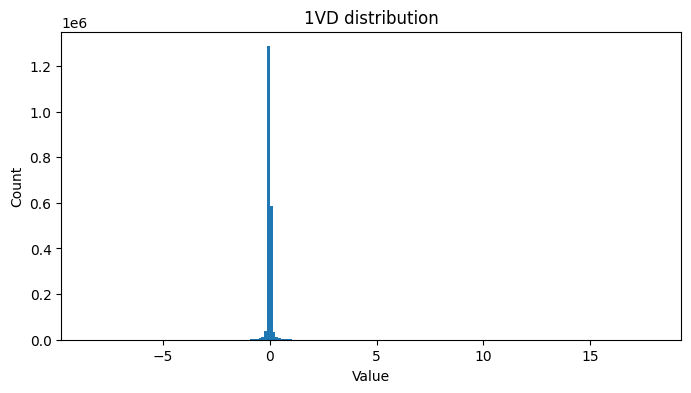

In [9]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def plot_hist(path, title, bins=200, sample=2_000_000):
    with rasterio.open(path) as src:
        arr = src.read(1, masked=True)
        data = arr.compressed()  # chỉ lấy valid pixels
        if data.size > sample:
            idx = np.random.choice(data.size, sample, replace=False)
            data = data[idx]

    plt.figure(figsize=(8,4))
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

plot_hist(files["tmi"], "TMI (nT) distribution")
plot_hist(files["rtp"], "RTP / VRTP (nT) distribution")
plot_hist(files["1vd"], "1VD distribution")


In [10]:
import rasterio

def grid_fingerprint(path):
    with rasterio.open(path) as src:
        return (str(src.crs), src.transform, src.width, src.height, src.res, src.nodata)

fps = {k: grid_fingerprint(p) for k,p in files.items()}
print("Same CRS?", len(set(fp[0] for fp in fps.values())) == 1)
print("Same transform?", len(set(str(fp[1]) for fp in fps.values())) == 1)
print("Same shape?", len(set((fp[2], fp[3]) for fp in fps.values())) == 1)
print("Same res?", len(set(fp[4] for fp in fps.values())) == 1)


Same CRS? True
Same transform? True
Same shape? True
Same res? True


In [12]:
with rasterio.open(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt\reprojected_28352\1vd_nt_28352.tif") as src:
    arr = src.read(1)   # numpy array

In [13]:
arr 

array([[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       ...,
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],
      shape=(20071, 10622), dtype=float32)

## Hàm resample chuẩn (dùng cho TMI / RTP / 1VD)

In [15]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin
import math
from pathlib import Path

def resample_raster(
    in_path,
    out_path,
    target_res=500,
    resampling=Resampling.bilinear
):
    """
    Resample raster to target resolution (meters).
    Assumes raster already in projected CRS (EPSG:28352).
    """

    in_path = Path(in_path)
    out_path = Path(out_path)

    with rasterio.open(in_path) as src:
        left, bottom, right, top = src.bounds

        dst_transform = from_origin(
            left, top, target_res, target_res
        )

        dst_width = math.ceil((right - left) / target_res)
        dst_height = math.ceil((top - bottom) / target_res)

        meta = src.meta.copy()
        meta.update({
            "transform": dst_transform,
            "width": dst_width,
            "height": dst_height,
            "compress": "lzw"
        })

        with rasterio.open(out_path, "w", **meta) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,
                resampling=resampling
            )


In [16]:
in_dir = Path(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt\reprojected_28352")
out_dir = Path(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt\resampled_500m")
out_dir.mkdir(exist_ok=True)

files = {
    "tmi": "tmi_nt_28352.tif",
    "rtp": "rtp_nt_28352.tif",
    "1vd": "1vd_nt_28352.tif",
}

for k, f in files.items():
    resample_raster(
        in_dir / f,
        out_dir / f"{k}_nt_500m.tif",
        target_res=500
    )


In [17]:
with rasterio.open(r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\processed_nt\resampled_500m\1vd_nt_500m.tif") as src:
    arr = src.read(1)   # numpy array

In [18]:
arr

array([[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       ...,
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],
      shape=(3750, 1985), dtype=float32)

In [19]:
out_dir

WindowsPath('C:/Users/Phong/Desktop/GIS/Project 2/3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)/processed_nt/resampled_500m')

## Tạo grid index (x, y) cho raster 500 m

In [20]:
import rasterio
import pandas as pd
import numpy as np

with rasterio.open(out_dir / "tmi_nt_500m.tif") as src:
    tmi = src.read(1)
    transform = src.transform

rows, cols = np.indices(tmi.shape)
xs, ys = rasterio.transform.xy(transform, rows, cols)

df = pd.DataFrame({
    "x": np.array(xs).ravel(),
    "y": np.array(ys).ravel(),
    "tmi": tmi.ravel()
})


In [21]:
df

,x,y,tmi
0,5.002750e+05,8.967518e+06,-99999.0
1,5.007750e+05,8.967518e+06,-99999.0
2,5.012750e+05,8.967518e+06,-99999.0
3,5.017750e+05,8.967518e+06,-99999.0
4,5.022750e+05,8.967518e+06,-99999.0
...,...,...,...
7443745,1.490275e+06,7.093018e+06,-99999.0
7443746,1.490775e+06,7.093018e+06,-99999.0
7443747,1.491275e+06,7.093018e+06,-99999.0
7443748,1.491775e+06,7.093018e+06,-99999.0


In [22]:
def read_raster_to_series(path, name):
    with rasterio.open(path) as src:
        arr = src.read(1)
    return pd.Series(arr.ravel(), name=name)

df["rtp"] = read_raster_to_series(out_dir / "rtp_nt_500m.tif", "rtp")
df["vd1"] = read_raster_to_series(out_dir / "1vd_nt_500m.tif", "vd1")


In [23]:
df.head()

,x,y,tmi,rtp,vd1
0,500275.019639,8.967518e+06,-99999.0,-99999.0,-99999.0
1,500775.019639,8.967518e+06,-99999.0,-99999.0,-99999.0
2,501275.019639,8.967518e+06,-99999.0,-99999.0,-99999.0
3,501775.019639,8.967518e+06,-99999.0,-99999.0,-99999.0
4,502275.019639,8.967518e+06,-99999.0,-99999.0,-99999.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7443750 entries, 0 to 7443749
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   tmi     float32
 3   rtp     float32
 4   vd1     float32
dtypes: float32(3), float64(2)
memory usage: 198.8 MB


In [25]:
# nodata = -99999

# mask = (
#     (df["tmi"] != nodata) &
#     (df["rtp"] != nodata) &
#     (df["vd1"] != nodata)
# )

# df_valid = df.loc[mask].reset_index(drop=True)

In [28]:
# df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6141820 entries, 0 to 6141819
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   tmi     float32
 3   rtp     float32
 4   vd1     float32
dtypes: float32(3), float64(2)
memory usage: 164.0 MB


In [30]:
# df_valid
df

,x,y,tmi,rtp,vd1
0,5.002750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
1,5.007750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
2,5.012750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
3,5.017750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
4,5.022750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
...,...,...,...,...,...
7443745,1.490275e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443746,1.490775e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443747,1.491275e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443748,1.491775e+06,7.093018e+06,-99999.0,-99999.0,-99999.0


In [32]:
out_dir

WindowsPath('C:/Users/Phong/Desktop/GIS/Project 2/3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)/processed_nt/resampled_500m')

In [34]:
out_path_save = r"C:\Users\Phong\Desktop\GIS\Project 2\3_Magnetic Anomaly Map of Australia (20192020 packages; GeoTIFFNetCDF)\features_magnetic_500m.parquet"
df.to_parquet(out_path_save, index=False)

In [35]:
df_load = pd.read_parquet(out_path_save)
df_load

,x,y,tmi,rtp,vd1
0,5.002750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
1,5.007750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
2,5.012750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
3,5.017750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
4,5.022750e+05,8.967518e+06,-99999.0,-99999.0,-99999.0
...,...,...,...,...,...
7443745,1.490275e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443746,1.490775e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443747,1.491275e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
7443748,1.491775e+06,7.093018e+06,-99999.0,-99999.0,-99999.0
